# Week 2 Linear Regression 

This notebook contains material relevant to performing multiple linear regression. 

Let us begin with the model definition. 

## Linear Regression Model

A linear regression model is:

$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i, i=1, \ldots, n$$

- $Y_i$ is the repsonse variate,
- $x_i$ is the predictor/covariate, 
- $n$ is the number of observations, and $\epsilon \sim N\left(0,\sigma^2\right)$



In [1]:
# Let's code it up, preamble first. 

import numpy as np # basic vector/matrix math
import matplotlib.pyplot as plt # plotting and illustrations 
import seaborn as sns # advanced plotting and illustrations. 
import pandas as pd # data loading, saving, and general data manipulation. 
import scipy.stats as stats # inter alia, statistical distributions, functions and relevant objects.
import scipy.optimize as optimize 
import torch # ML/AI model's and general optimization 

In [2]:
def generate_lm_data(betas: np.array, n: int = 100, sigma: float = 1.0):
  """
    Generates a standard linear model with noise equal to sigma, and slope/intercept 
    respectively.

    Returns a tuple np.array, x,y 
  """

  
  eps = np.random.normal(0, sigma, size=n) # start with white noise. 

  # lets let the covariate be normally distributed as well.
  mu_x = 1.5
  sigma_x = 2.0 
  x = np.random.normal(mu_x, sigma_x, size=n)

  y = betas[0] + betas[1] * x + eps
  return (x, y)

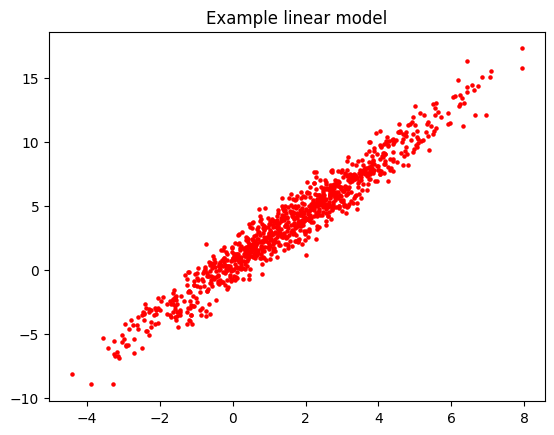

In [3]:
# let us plot the linear model and see what it looks like
x,y = generate_lm_data(betas = np.array([0.5, 2.0]), 
                       n = 1000,
                       sigma = 1.0)
plt.scatter(x,y, s=5, color = 'red')
plt.title("Example linear model");

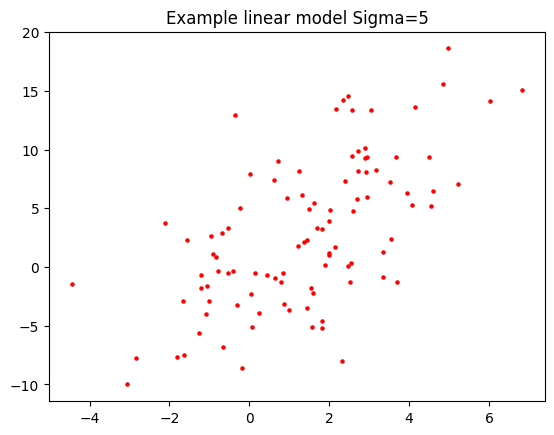

In [4]:
# let's experiment with the variation of noise level. 

# let us plot the linear model and see what it looks like
x,y = generate_lm_data(betas = np.array([0.5, 2.0]), 
                       n = 100,
                       sigma = 5.0)
plt.scatter(x,y, s=5, color = 'red')
plt.title(f"Example linear model Sigma={5}");

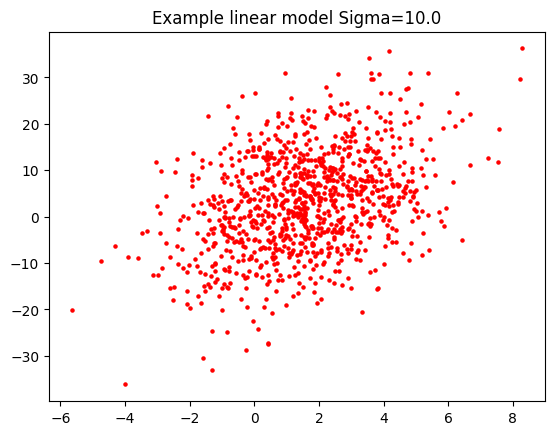

In [5]:
# let's experiment with the variation of noise level. 

# let us plot the linear model and see what it looks like
x,y = generate_lm_data(betas = np.array([0.5, 2.0]), 
                       n = 1000,
                       sigma = 10.0)
plt.scatter(x,y, s=5, color = 'red')
plt.title(f"Example linear model Sigma={10.0}");

In [6]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

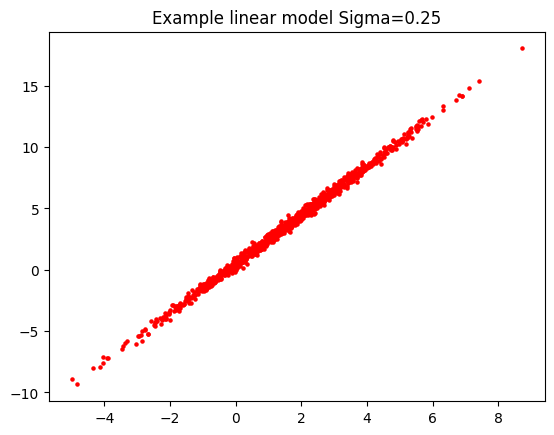

In [7]:
# let's experiment with the variation of noise level. 

# let us plot the linear model and see what it looks like
x,y = generate_lm_data(betas = np.array([0.5, 2.0]), 
                       n = 1000,
                       sigma = 0.25)
plt.scatter(x,y, s=5, color = 'red')
plt.title(f"Example linear model Sigma={0.25}");

# Linear Regression Statistical Assumptions

1. For any value of $x$, $y$ is a $N\left(\beta_0 + \beta_1 x, \sigma^2 \right)$ random variable.

2. Independence: $y_1, \ldots, y_n$ are statistically independent.

3. Linearity: The mean value of $y$ is a linear function of $x$.

4. Homoscedasticity: The variance of $y$ is the same for any $x$.


In [8]:
# lets see what happens when we break number 4. 

In [9]:
def generate_lm_heteroscedastic_data(betas: np.array, n: int = 100, lmbda: float = 1.0):
  """
    Generates a non-linear noise linear model with noise distributed exponential rate lmbda, and slope/intercept 
    respectively.

    Returns a tuple np.array, x,y 
  """

  sigma = np.random.exponential(lmbda, size=n)
  
  eps = np.random.normal(0, sigma, size=n) # start with white noise. 

  # lets let the covariate be normally distributed as well.
  mu_x = 1.5
  sigma_x = 2.0 
  x = np.random.normal(mu_x, sigma_x, size=n)

  y = betas[0] + betas[1] * x + eps
  return (x, y)

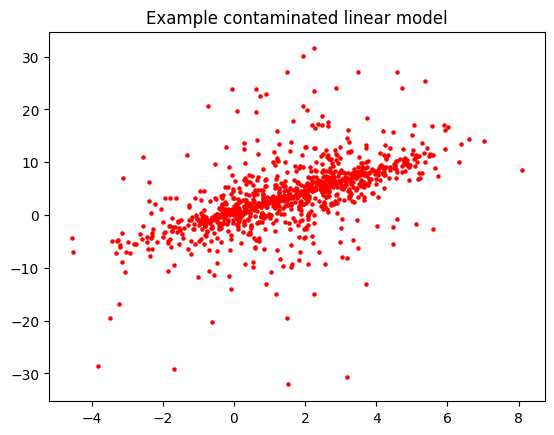

In [10]:
# let us plot the linear model and see what it looks like
x,y = generate_lm_heteroscedastic_data(betas = np.array([0.5, 2.0]), 
                       n = 1000,
                       lmbda = 4.0)
plt.scatter(x,y, s=5, color = 'red')
plt.title("Example contaminated linear model");

# noise levels look heterogeneous

In [11]:
# lets try a different variation, 

def generate_lm_heteroscedastic_data(betas: np.array, n: int = 100):
  """
    Generates a non-linear noise linear model with noise distributed exponential rate correlated to x, and slope/intercept 
    respectively.

    Returns a tuple np.array, x,y 
  """
 # lets let the covariate be normally distributed as well.
  mu_x = 1.5
  sigma_x = 2.0 
  x = np.random.normal(mu_x, sigma_x, size=n)

  sigma = np.random.exponential(np.abs(x), size=n)
  
  eps = np.random.normal(0, sigma, size=n) # start with white noise. 

 

  y = betas[0] + betas[1] * x + eps
  return (x, y)

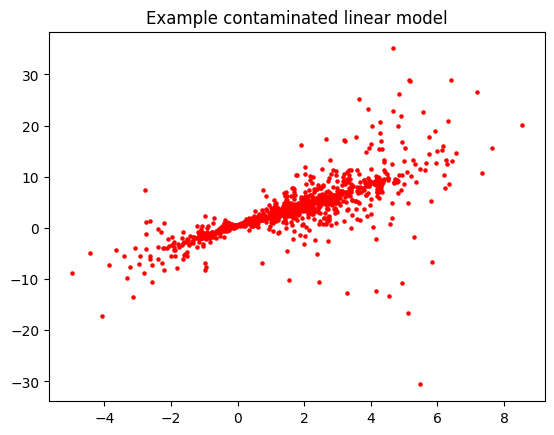

In [12]:
# let us plot the linear model and see what it looks like
x,y = generate_lm_heteroscedastic_data(betas = np.array([0.5, 2.0]), 
                       n = 1000)
plt.scatter(x,y, s=5, color = 'red')
plt.title("Example contaminated linear model");

# noise levels look heterogeneous

# Estimating Regression Coefficients

Estimates of the regression coefficients $\beta_0, \beta_1$ are obtained by minimizing:

$$\underset{\beta_0, \beta_1}{\arg \min} \sum_{i=1}^n \left(y_i- (\beta_0 + \beta_1 x_i) \right)^2.$$

Using calculus there are closed form expressions for the minimizers: $\hat \beta_0, \hat \beta_1.$

The prediction for $y$ based on the $i^{th}$ value of $x$ is: $$\hat y_i = \hat \beta_0 + \hat \beta_1x_i.$$

$e_i = y_i-\hat y_i$ is the $i^{th}$ residual, and the residual sum of squares is $$RSS=\sum_{i=1}^n e_i^2.$$



$$R^2 = 1- \frac{\sum_{i=1}^n (y_i-\hat y_i)^2}{\sum_{i=1}^n (y_i - \bar y_i)^2}$$

In [13]:
def fit_lm(X: np.array, y: np.array) -> dict:
  """
    Fits a basic linear model for closed form expressions for betas, output contains the following
    { y_hat, y, RSS, betas }

  """

  # check if X is appropriate shape. 
  if len(X.shape) != 2: 
    raise Exception("X is not an appropriate design matrix")
  
  if y.shape[0] != X.shape[0]:
    raise Exception("X, y pair is no appropriate")

  # calculate closed form expression
  X_block = np.transpose(X) @ X 
  y_block = np.transpose(X) @ y
  betas = np.linalg.inv(X_block) @ y_block
  y_hat = X @ betas

  # calculate SSE 
  n = X.shape[0]
  RSS = np.sum((y - y_hat)**2) / (n-1) 

  rsquared = 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)

  # results
  results = {
      'y':y, 
      'y_hat':y_hat, 
      'RSS': RSS, 
      'betas': betas,
      'rsquared': rsquared
  }

  return results 

In [14]:
# first example
x,y = generate_lm_data(betas = np.array([0.5, 2.0]), 
                       n = 1000,
                       sigma = 1.0)

In [16]:
X = np.stack((x, np.ones_like(x)), axis=1)

In [19]:
lm = fit_lm(X,y)
lm["betas"]

array([2.00360503, 0.49758447])

Text(0.5, 1.0, 'Linear Model fit comparison')

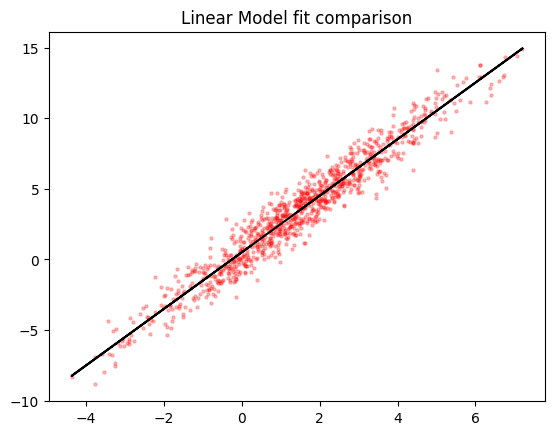

In [25]:
plt.scatter(x,y, s = 5, c = 'red', alpha = 0.25)
plt.plot(x,lm['y_hat'], c = 'black')
plt.title("Linear Model fit comparison")

In [26]:
lm['RSS']

0.9826694485106834

In [27]:
lm['rsquared'] # proportion of variance explained by data. 

0.939494636733275

# Linear Model Libraries

They are generally good, but I personally don't trust them. If you work with a library long enough you will find out some idiosyncrasies that will generate some results that may hurt your analysis. Generally, GLM/LM models are well programmed lets use some of them. 

In [29]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import linregress

In [ ]:

# store in pandas df
data = pd.DataFrame({'y': y, 'x':x}) 

#use stats models ols using R like formulas
Model = smf.ols("y ~ x", data = data).fit()

# display results...
print(Model.summary()) # utter chaos. 
print('\n RSE:', np.round(Model.ssr/Model.df_resid,2))
# learn to understand equations/ models, rather than outputs, both the output of this model 
# and my function above here has the same beta coefficient fit. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.467e+04
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        15:40:08   Log-Likelihood:                -1459.7
No. Observations:                1000   AIC:                             2923.
Df Residuals:                     998   BIC:                             2933.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4840      0.042     11.553      0.0

In [ ]:
lm['betas']

array([2.00437203, 0.48404638])